In [1]:
import sys
sys.path.append('../utils')

In [2]:
# Import packages
from caveclient import CAVEclient
#import skeleton_plot as skelplot

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.sparse import csr_array
from typing import Union, Optional
from utils import check_index, adjacencyplot
from os.path import join as pjoin
import itertools
import scipy.spatial as spatial

In [79]:
## UTILS

def filter_synapse_table(
    synapse_table: pd.DataFrame, pre_root_ids=None, post_root_ids=None
):
    """Filter synapse table by pre and post root ids.

    Args:
        synapse_table: synapse table with pre_pt_root_ids and post_pt_root_ids as pd.DataFrame
        pre_root_ids: np.ndarray, list or pd.Series if root_ids to filter on the presynaptic side
        post_root_ids: np.ndarray, list or pd.Series if root_ids to filter on the postsynaptic side

    Returns:
        synapse_table: filtered synapse table
    """

    if pre_root_ids is not None:
        assert isinstance(pre_root_ids, (np.ndarray, list, pd.core.series.Series)), (
            f"IDs have to be of type np.ndarray, list or pd.Series; got {type(pre_root_ids)}"
        )
        pre_mask = np.isin(synapse_table["pre_pt_root_id"], pre_root_ids)
    else:
        pre_mask = np.ones(len(synapse_table), dtype=bool)

    if post_root_ids is not None:
        assert isinstance(post_root_ids, (np.ndarray, list, pd.core.series.Series)), (
            f"IDs have to be of type np.ndarray, list or pd.Series; got {type(pre_root_ids)}"
        )
        post_mask = np.isin(synapse_table["post_pt_root_id"], post_root_ids)
    else:
        post_mask = np.ones(len(synapse_table), dtype=bool)

    return synapse_table[pre_mask & post_mask]


def make_adjacency(
    synapses,
    source_cell_index: Union[pd.Index, pd.DataFrame, pd.Series, np.ndarray, list],
    target_cell_index: Optional[
        Union[pd.Index, pd.DataFrame, pd.Series, np.ndarray, list]
    ] = None,
    aggfunc="binary",
    return_as="dense",
) -> Union[csr_array, np.ndarray]:
    source_cell_index = check_index(source_cell_index)
    if target_cell_index is None:
        target_cell_index = source_cell_index
    else:
        target_cell_index = check_index(target_cell_index)
    synapses = synapses.query(
        "pre_pt_root_id in @source_cell_index and post_pt_root_id in @target_cell_index"
    )
    groupby = synapses.groupby(["pre_pt_root_id", "post_pt_root_id"])
    if aggfunc == "count":
        edges = groupby.size().rename("weight").reset_index()
    elif aggfunc == "binary":
        edges = groupby.size().transform(lambda x: x > 0).rename("weight").reset_index()
    else:
        edges = groupby["size"].agg(aggfunc).rename("weight").reset_index()
    # make sure that the adjacency matrix is sorted the same as the input cell index
    edges["source_index"] = source_cell_index.get_indexer(edges["pre_pt_root_id"])
    edges["target_index"] = target_cell_index.get_indexer(edges["post_pt_root_id"])
    adjacency = csr_array(
        (edges["weight"], (edges["source_index"], edges["target_index"])),
        shape=(len(source_cell_index), len(target_cell_index)),
        dtype=edges["weight"].dtype,
    )
    # NOTE: for many applications working with sparse matrices is more efficient
    # but for ease of use and visualization in this workshop we return a dense matrix
    if return_as == "dense":
        adjacency = adjacency.todense()
    elif return_as == "sparse":
        pass  # already in sparse format
    else:
        raise ValueError(f"Unknown return_as type: {return_as}")
    return adjacency



def calculate_neuronal_distance(pre_cell_df, post_cell_df=None, distance_type="lateral"):

    if distance_type == "lateral":
        dist_columns = ["pt_position_trform_x", "pt_position_trform_z"]
    elif distance_type == "vertical":
        dist_columns = ["pt_position_trform_y"]
    elif distance_type == "3d":
        dist_columns = ["pt_position_trform_x", "pt_position_trform_y", "pt_position_trform_z"]

    
    if post_cell_df is None:
        post_cell_df = pre_cell_df
    
    pre_lateral_locations = np.array(pre_cell_df[dist_columns])
    post_lateral_locations = np.array(post_cell_df[dist_columns])
    lateral_distances = spatial.distance.cdist(pre_lateral_locations, post_lateral_locations)
    
    id_pairs = list(itertools.product(pre_cell_df["pt_root_id"], post_cell_df["pt_root_id"]))
    
    lateral_distance_df = pd.DataFrame(id_pairs, columns=['pre_pt_root_id', 'post_pt_root_id'])
    lateral_distance_df['distance'] = lateral_distances.flatten()

    lateral_distance_df = lateral_distance_df[lateral_distance_df['pre_pt_root_id'] != lateral_distance_df['post_pt_root_id']]
    return lateral_distance_df

In [66]:
data_dir = '/Users/rodrigo.gonzalezlaiz/Desktop/v1dd_1196'
mat_version = '1196'

In [67]:
# Loads cells with axon and dendrite proofreading
dendrite_proof_root_ids = np.load(
    pjoin(data_dir, f"proofread_dendrite_list_{mat_version}.npy")
)
axon_proof_root_ids = np.load(pjoin(data_dir, f"proofread_axon_list_{mat_version}.npy"))

print(
    f"There are {len(dendrite_proof_root_ids)} cells with acceptable dendrites, and {len(axon_proof_root_ids)} cells with axon proofreading"
)
print(
    f"The number of cells with usable axons and dendrites is: {(np.isin(axon_proof_root_ids, dendrite_proof_root_ids).sum())}"
)

There are 63986 cells with acceptable dendrites, and 1210 cells with axon proofreading
The number of cells with usable axons and dendrites is: 1148


In [68]:
syn_df = pd.read_feather(
    f"{data_dir}/syn_df_all_to_proofread_to_all_{mat_version}.feather"
)

print(syn_df.shape)

syn_df.head(3)

(8204497, 13)


,id,pre_pt_position_x,pre_pt_position_y,pre_pt_position_z,post_pt_position_x,post_pt_position_y,post_pt_position_z,ctr_pt_position_x,ctr_pt_position_y,ctr_pt_position_z,size,pre_pt_root_id,post_pt_root_id
0,354386968,758200.5,802316.1,304380.0,757861.0,802558.6,304650.0,757967.7,802597.4,304380.0,240,864691132536286810,864691132734919083
1,378070488,792063.2,514342.5,183735.0,792664.6,514284.3,183915.0,792412.4,514294.0,183735.0,3056,864691132572190492,864691132606767301
2,499493001,977071.3,390075.8,191340.0,976974.3,390104.9,190935.0,976838.5,390337.7,190935.0,1346,864691132573738810,864691132747578447


In [69]:
syn_df.columns

Index(['id', 'pre_pt_position_x', 'pre_pt_position_y', 'pre_pt_position_z',
       'post_pt_position_x', 'post_pt_position_y', 'post_pt_position_z',
       'ctr_pt_position_x', 'ctr_pt_position_y', 'ctr_pt_position_z', 'size',
       'pre_pt_root_id', 'post_pt_root_id'],
      dtype='object')


This table has a number of columns, we will highlight the most important:

- **id:** a unique ID for each synapse
- **pre_pt_root_id:** the segmentation ID of the pre-synaptic compartment
- **post_pt_root_id:** the segmentation ID of the post-synaptic compartment
- **size:** a measure of the synapse size (the number of 4,4,40 nm voxels in the synapse mask) best available metric of synaptic weight
- **ctr_pt_position_{x,y,z}:** the location of the synapse in the cleft, stored here in nanometers
- **pre_pt_position_{x,y,z}:** a point just in the presynaptic compartment of synapse (used to lookup pre_root_id), stored here in nanometers
- **post_pt_position_{x,y,z}:** a point just in the postsynaptic compartment of synapse (used to lookup post_pt_root_id), stored here in nanometers

### Compartment types:
- 0: undefined
- 1: soma (default color 'olive')
- 2: axon (default color 'steelblue')
- 3: (basal) dendrite (default color 'firebrick' red)
- 4: apical dendrite
- 5+: custom

In [175]:
# get the ids of all proofread cells with both axon and dendrite proofreading
proof_root_ids = axon_proof_root_ids[
    np.isin(axon_proof_root_ids, dendrite_proof_root_ids)
]

#NOTE(Rodrigo): proof_root_ids contains both "presynaptic" and "postsynaptic" root ids.

# filter for synapses between the proofread cells (pre and post)
proof_proof_syn_table = filter_synapse_table(
    syn_df, pre_root_ids=proof_root_ids, post_root_ids=proof_root_ids
)

In [176]:
proof_root_ids.shape

(1148,)

In [9]:
proof_proof_syn_table.shape

(195304, 13)

In [10]:
# Check for duplicates in pre_pt_root_id and post_pt_root_id
print("Duplicates in pre_pt_root_id:")
print(syn_df['pre_pt_root_id'].duplicated().sum())
print("\nDuplicates in post_pt_root_id:")
print(syn_df['post_pt_root_id'].duplicated().sum())

# Check for duplicate pairs of pre_pt_root_id and post_pt_root_id
print("\nDuplicate pre-post pairs:")
duplicate_pairs = syn_df.duplicated(subset=['pre_pt_root_id', 'post_pt_root_id'])
print(duplicate_pairs.sum())

# Check for rows where pre_pt_root_id == post_pt_root_id (self-synapses)
print("\nSelf-synapses (pre_pt_root_id == post_pt_root_id):")
self_synapses = syn_df['pre_pt_root_id'] == syn_df['post_pt_root_id']
print(self_synapses.sum())

Duplicates in pre_pt_root_id:
4682321

Duplicates in post_pt_root_id:
7448795

Duplicate pre-post pairs:
1425662

Self-synapses (pre_pt_root_id == post_pt_root_id):
0


In [11]:
# How does ensemble membership affect connectivity?
# H: Neurons within an ensemble will have more connectivity.
# Neurons in multiple ensembles will have more but weaker connections.


In [12]:
# filter for synapses between the proofread cells (pre and post)
proof_proof_syn_table = filter_synapse_table(
    syn_df, pre_root_ids=proof_root_ids, post_root_ids=proof_root_ids,
)

In [13]:
syn_mat = make_adjacency(proof_proof_syn_table, proof_root_ids, aggfunc="binary")
syn_mat.shape

(1148, 1148)

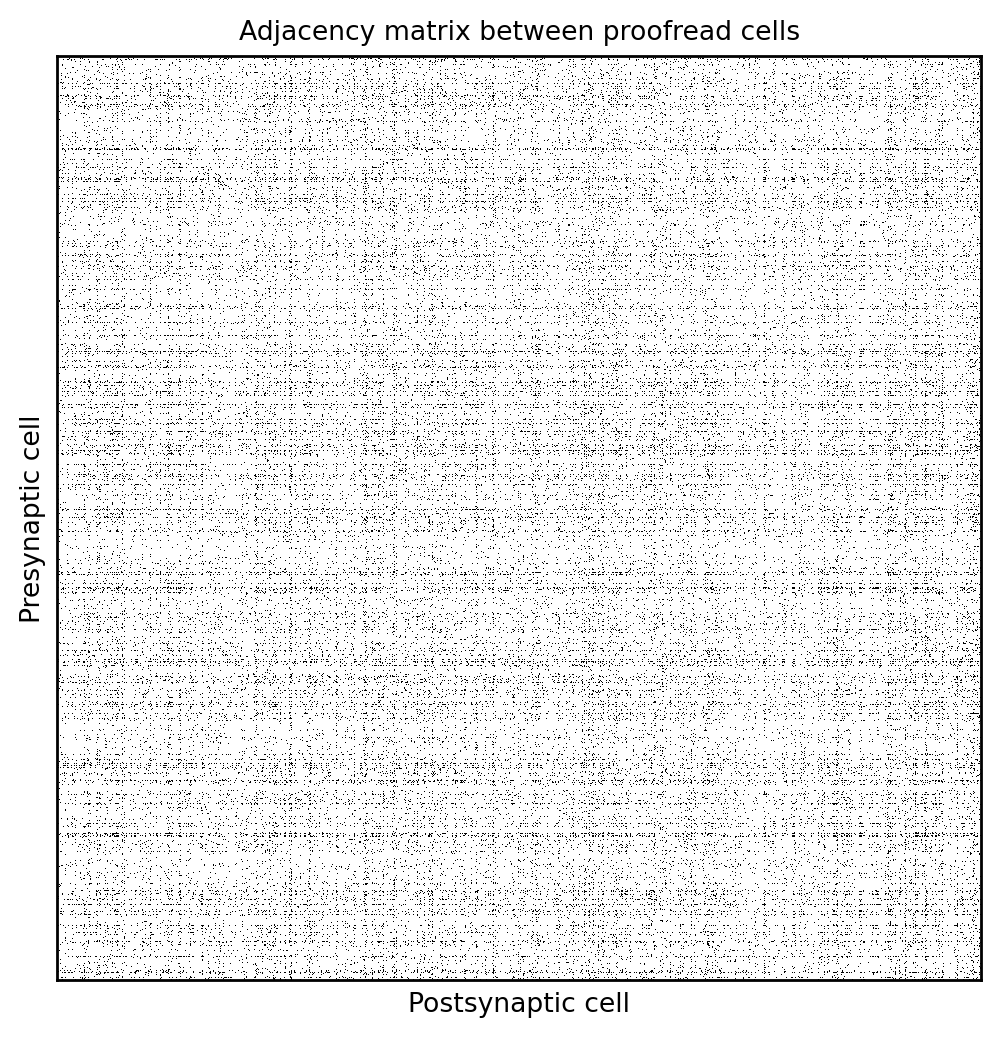

In [14]:
sns.set_context("paper", font_scale=1.0)

fig, ax = plt.subplots(figsize=(6, 6), dpi=200)

sns.heatmap(
    syn_mat,
    cbar=False,
    cmap="Greys",
    xticklabels=False,
    yticklabels=False,
    square=True,
    ax=ax,
)
ax.spines[["left", "right", "top", "bottom"]].set_visible(True)
_ = ax.set(
    xlabel="Postsynaptic cell",
    ylabel="Presynaptic cell",
    title="Adjacency matrix between proofread cells",
)

## Cell type

In [ ]:
cell_df = pd.read_feather(f"{data_dir}/soma_and_cell_type_{mat_version}.feather")
# *Note:* Cells here without a label will remain black. These are either non-neuronal cells or potential neurons with large segmentation errors that did not pass quality check


cell_df['depth_um'] = cell_df['pt_position_trform_y'] / 1_000 # from nm to um

In [16]:
cell_df.head()

,id,pt_position_x,pt_position_y,pt_position_z,pt_position_trform_x,pt_position_trform_y,pt_position_trform_z,pt_root_id,volume,cell_type_coarse,cell_type
0,228132,632828,749849,738270,-323721.447979,549910.283106,392909.832613,864691132737039043,458.464831,None,None
1,543247,1304922,977915,83880,330339.020171,595962.275760,-306424.551354,864691132730839988,73.345940,None,None
2,203262,624680,531094,283770,-252082.627894,203770.728235,21544.029756,864691132654552792,338.276613,E,L3-IT
3,350562,894573,478559,163530,20989.259196,117514.626427,-98554.035375,864691132773514104,326.965400,E,L2-IT
4,718122,1729859,674111,781200,803635.726721,475075.415268,467669.881328,864691132774106773,333.888647,None,None


In [166]:
cell_df.shape

(207455, 11)

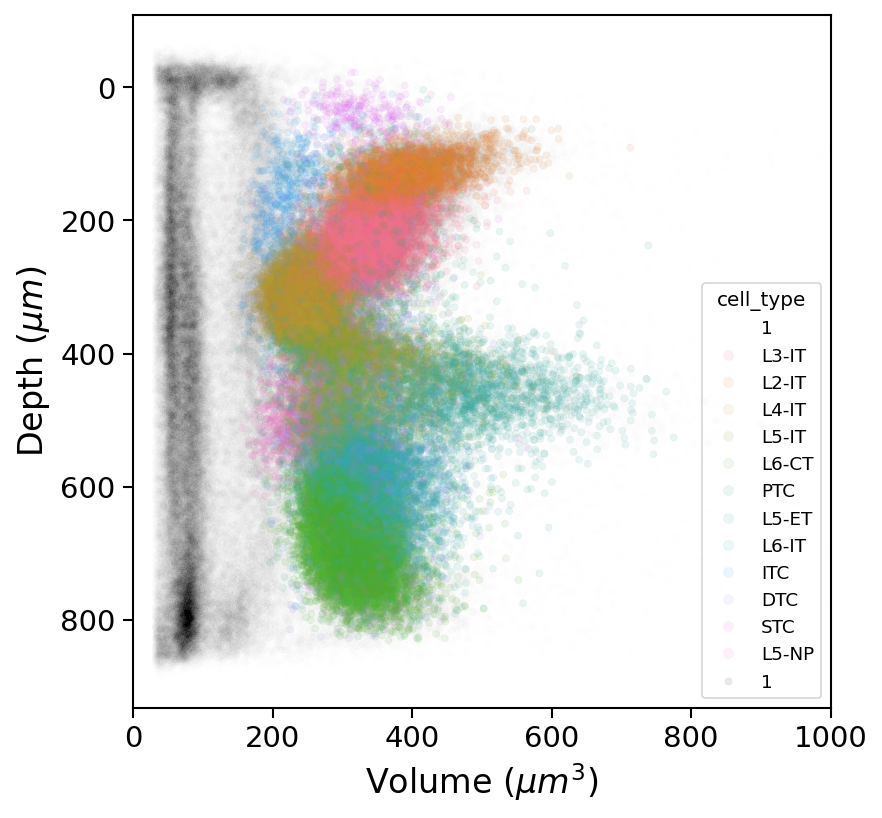

In [19]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=150)
ax.tick_params(labelsize=14)
sns.scatterplot(
    data=cell_df,  # this is the dataframe
    x="volume",
    y="depth_um",
    size=1,
    edgecolor=None,
    alpha=0.005,
    color="k",
    ax=ax,
    legend=True,
)
sns.scatterplot(
    data=cell_df,
    x="volume",
    y="depth_um",
    size=1,
    edgecolor=None,
    alpha=0.1,
    color="k",
    ax=ax,
    legend=True,
    hue="cell_type",
)
ax.invert_yaxis()
ax.set_xlabel(r"Volume ($\mu m^3$)", fontsize=16)
ax.set_ylabel(r"Depth ($\mu m$)", fontsize=16)
ax.set_xlim(0, 1000)
plt.show()

## Compute STRUCTURAL null connectivity

In [ ]:
syn_df = pd.read_feather(f"{data_dir}/syn_df_all_to_proofread_to_all_{mat_version}.feather")
cell_df = pd.read_feather(f"{data_dir}/soma_and_cell_type_{mat_version}.feather")

cell_df[[col for col in cell_df.columns if "position" in col]] /= 1000.


# note (rodrigo): in the workshop they only use the axon proofread cells (1164 cells)
cell_df_proofread = cell_df[np.isin(cell_df['pt_root_id'], axon_proof_root_ids) & np.isin(cell_df['pt_root_id'], dendrite_proof_root_ids)]
cell_df_proofread_l3 = cell_df_proofread[cell_df_proofread["cell_type"] == "L3-IT"]

In [186]:
syn_df.shape, cell_df.shape, cell_df_proofread.shape

((8204497, 13), (207455, 11), (1164, 11))

In [144]:
# only use synapses with proofread cells
analysis_syn_df = filter_synapse_table(syn_df, proof_root_ids, proof_root_ids).reset_index(drop=True)

# NOTE: group by pre-post pairs and sum the synapse size --> all couple of pre-post neurons have a number that is how strong the synapse is 
conn_df = analysis_syn_df.groupby(["pre_pt_root_id", "post_pt_root_id"])["size"].sum().reset_index()

In [152]:
distance_df = calculate_neuronal_distance(cell_df_proofread, distance_type="vertical")
distance_df.head(5)

,pre_pt_root_id,post_pt_root_id,distance
1,864691132625300120,864691132710501931,61.165998
2,864691132625300120,864691132923215329,79.868920
3,864691132625300120,864691132616354625,0.953243
4,864691132625300120,864691132999200949,148.717104
5,864691132625300120,864691132657293527,42.490965


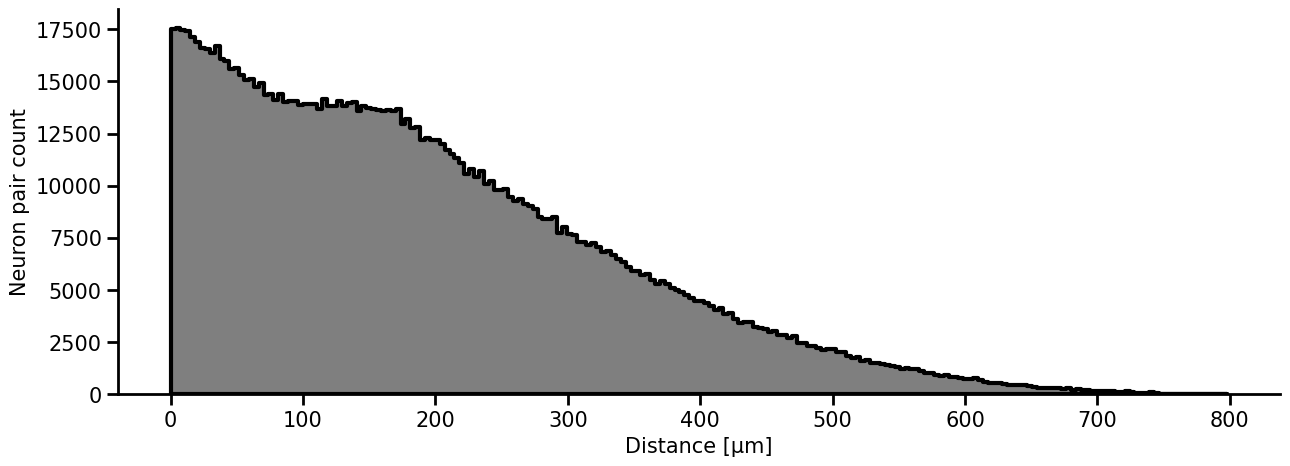

In [153]:
fig, ax = plt.subplots(figsize=(15, 5))

sns.histplot(distance_df, x="distance", fill=True, alpha=.5, color="k", lw=3, element="step")

ax.tick_params(axis='both', which='major', labelsize=15, width=2, length=8)  
ax.tick_params(axis='both', which='minor', labelsize=14, width=1, length=4)  

ax.spines['top'].set_visible(False) 
ax.spines['right'].set_visible(False) 
ax.spines['bottom'].set_linewidth(2)  
ax.spines['left'].set_linewidth(2) 

ax.set_xlabel("Distance [µm]", fontsize=15)
ax.set_ylabel("Neuron pair count", fontsize=15)

plt.show()

In [154]:
proof_root_ids = axon_proof_root_ids[
    np.isin(axon_proof_root_ids, dendrite_proof_root_ids)
]

In [155]:
# merge the two dataframes on the pre-post pairs
conn_dist_df = pd.merge(conn_df, distance_df, on = ['pre_pt_root_id', 'post_pt_root_id'])

In [156]:
conn_dist_df.shape

(90845, 4)

In [201]:
conn_dist_df

,pre_pt_root_id,post_pt_root_id,size,distance
0,864691132534275418,864691132619649223,2620,135.078530
1,864691132534275418,864691132656860272,898,43.730978
2,864691132534275418,864691132659029623,3828,36.179625
3,864691132534275418,864691132663192644,4488,167.084951
4,864691132534275418,864691132663898692,1556,309.583321
...,...,...,...,...
90840,864691133313665616,864691132852413955,2673,71.333658
90841,864691133313665616,864691132973162293,2758,94.785972
90842,864691133313665616,864691132980861372,2643,136.582035
90843,864691133313665616,864691133121872229,502,62.241160


In [204]:
connected_pair_counts

array([4676, 4714, 4566, 4330, 4324, 4284, 4090, 3774, 3679, 3517, 3435,
       3125, 2950, 2740, 2546, 2343, 2217, 2040, 1927, 1748, 1648, 1569,
       1438, 1324, 1316, 1320, 1208, 1130, 1068,  978,  932,  804,  754,
        730,  705,  580,  572,  485,  463,  447,  425,  380,  338,  337,
        311,  296,  235,  231,  224,  230,  183,  172,  143,  117,  110,
         88,   68,   52,   43,   41,   28,   36,   27,   26,   19,   22,
         15,   12,   15,   12,   12,   10,    6,    8,    9,    7,   11,
          4,   13,    5,    4,    8,    1,    3,    3,    1,    3,    0,
          2,    1,    1,    1,    0,    0,    0,    0,    0,    0,    0,
          0])

In [205]:
proofread_pair_counts

array([37876, 37476, 36686, 35528, 35432, 34220, 33404, 32586, 31722,
       30858, 30770, 30434, 29898, 30090, 30066, 29932, 30084, 29828,
       29842, 29412, 29458, 29074, 28184, 27106, 26418, 26150, 24852,
       23940, 23100, 22348, 21700, 21188, 20044, 19990, 19030, 18160,
       17598, 16956, 16170, 15620, 15264, 14674, 13892, 12962, 12600,
       12006, 11518, 11230, 10352,  9918,  9614,  8976,  8454,  7882,
        7540,  6920,  6646,  6302,  6062,  5452,  5016,  4762,  4720,
        4348,  3906,  3606,  3276,  3172,  2880,  2706,  2590,  2244,
        2086,  1922,  1734,  1646,  1502,  1270,  1130,  1028,   966,
         824,   684,   650,   614,   536,   466,   362,   372,   274,
         268,   180,   174,   134,    76,    42,    28,    22,    18,
           4])

In [206]:
conn_dist_df

,pre_pt_root_id,post_pt_root_id,size,distance
0,864691132534275418,864691132619649223,2620,135.078530
1,864691132534275418,864691132656860272,898,43.730978
2,864691132534275418,864691132659029623,3828,36.179625
3,864691132534275418,864691132663192644,4488,167.084951
4,864691132534275418,864691132663898692,1556,309.583321
...,...,...,...,...
90840,864691133313665616,864691132852413955,2673,71.333658
90841,864691133313665616,864691132973162293,2758,94.785972
90842,864691133313665616,864691132980861372,2643,136.582035
90843,864691133313665616,864691133121872229,502,62.241160


In [157]:
bins = np.linspace(0, distance_df["distance"].max(), 101) # 5µm bins

# Binned counts for proofread and connected pairs
proofread_pair_counts = np.histogram(distance_df["distance"], bins)[0]
connected_pair_counts = np.histogram(conn_dist_df["distance"], bins)[0]

# Fraction of counts between connected and proofread pairs
connection_probability = connected_pair_counts / proofread_pair_counts
connection_probability_df = pd.DataFrame({"bin_id": np.arange(len(bins)-1), "probability": connection_probability})

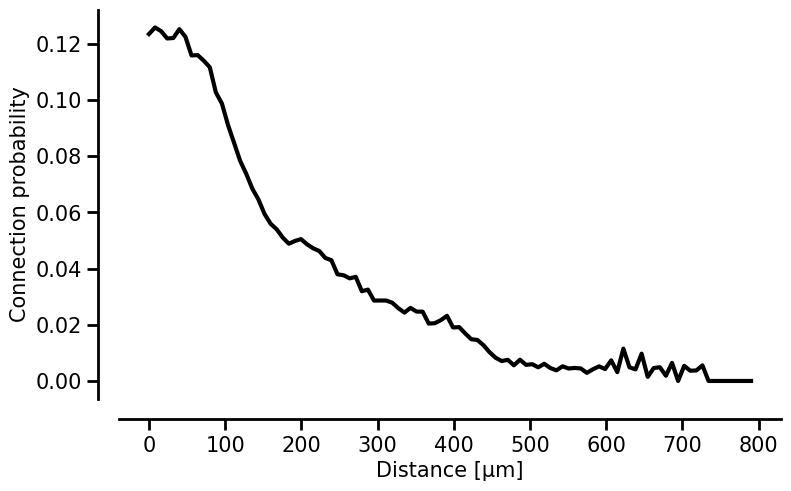

In [158]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(x=bins[:-1], y=connection_probability, lw=3, color="k")

ax.tick_params(axis='both', which='major', labelsize=15, width=2, length=8)  # Set larger tick labels
ax.tick_params(axis='both', which='minor', labelsize=14, width=1, length=4)  # Set larger tick labels

ax.spines['top'].set_visible(False)  # Hide the top spine
ax.spines['right'].set_visible(False)  # Hide the right spine
ax.spines['bottom'].set_linewidth(2)  # Hide the top spine
ax.spines['left'].set_linewidth(2)  # Hide the right spine

ax.set_xlabel("Distance [µm]", fontsize=15)
ax.set_ylabel("Connection probability", fontsize=15)

sns.despine(offset=15, trim=False)
plt.tight_layout()
plt.show()

## Null distribution based on cell type

In [165]:
cell_df_proofread

,id,pt_position_x,pt_position_y,pt_position_z,pt_position_trform_x,pt_position_trform_y,pt_position_trform_z,pt_root_id,volume,cell_type_coarse,cell_type
159,293764,878.665,697.702,245.475,-17.654153,354.663188,-51.618076,864691132625300120,231.369357,E,L4-IT
956,295576,842.193,737.122,325.260,-67.856489,415.829186,13.006444,864691132710501931,453.768761,E,L5-IT
1412,278405,737.898,601.710,294.075,-145.995980,274.794268,19.379727,864691132923215329,336.579200,I,DTC
1779,293733,858.877,700.030,240.210,-37.633020,355.616431,-57.338047,864691132616354625,260.410740,I,ITC
1991,307952,867.646,840.563,262.935,-69.027466,503.380292,-79.655916,864691132999200949,352.843100,E,L5-IT
...,...,...,...,...,...,...,...,...,...,...,...
206432,425364,1135.055,574.783,189.495,257.331255,218.305414,-78.400099,864691132819642111,159.295394,I,ITC
206433,385115,975.354,850.418,394.650,17.544598,553.562858,34.298148,864691132679146333,325.794498,E,L6-IT
206511,383491,928.872,797.418,316.125,3.578300,473.261098,-13.876769,864691132663975748,457.329970,E,L5-IT
207004,351167,927.863,548.865,192.105,51.726444,194.685171,-72.918410,864691132579592205,370.358383,I,PTC


In [170]:
proof_root_ids.shape

(1148,)

In [172]:
cell_df_proofread.shape

(1164, 11)

In [ ]:
cell_df = pd.read_feather(f"{data_dir}/soma_and_cell_type_{mat_version}.feather")
# *Note:* Cells here without a label will remain black. These are either non-neuronal cells or potential neurons with large segmentation errors that did not pass quality check


cell_df['depth_um'] = cell_df['pt_position_trform_y'] / 1_000 # from nm to um

In [187]:
analysis_syn_df.shape

(195304, 13)

In [190]:
# Add cell type information for presynaptic and postsynaptic neurons
analysis_syn_df = analysis_syn_df.merge(
    cell_df_proofread[['pt_root_id', 'cell_type_coarse']].rename(columns={'pt_root_id': 'pre_pt_root_id', 'cell_type_coarse': 'pre_cell_type_coarse'}),
    on='pre_pt_root_id',
    how='left'
)

analysis_syn_df = analysis_syn_df.merge(
    cell_df_proofread[['pt_root_id', 'cell_type_coarse']].rename(columns={'pt_root_id': 'post_pt_root_id', 'cell_type_coarse': 'post_cell_type_coarse'}),
    on='post_pt_root_id',
    how='left'
)

analysis_syn_df

,id,pre_pt_position_x,pre_pt_position_y,pre_pt_position_z,post_pt_position_x,post_pt_position_y,post_pt_position_z,ctr_pt_position_x,ctr_pt_position_y,ctr_pt_position_z,size,pre_pt_root_id,post_pt_root_id,pre_cell_type_coarse,post_cell_type_coarse
0,461895313,917998.3,772740.8,284220.0,918376.6,772818.4,283815.0,918202.0,773080.3,284085.0,540,864691132557909513,864691132931817448,I,E
1,301049004,679950.6,813121.9,283050.0,679552.9,812753.3,283095.0,679601.4,812782.4,283140.0,958,864691132578625044,864691132931817448,I,E
2,436596114,879663.9,750576.3,347715.0,879266.2,750653.9,348120.0,879469.9,750634.5,347940.0,266,864691132557909513,864691132931817448,I,E
3,363374679,781538.7,726132.3,241110.0,781257.4,726268.1,240480.0,781305.9,725986.8,240705.0,396,864691132578625044,864691132786109590,I,I
4,491726200,962385.5,676759.3,316035.0,962210.9,677069.7,316620.0,962366.1,676856.3,316305.0,442,864691132562471396,864691132773784759,I,E
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195299,392461779,810570.8,718508.1,268200.0,810881.2,718634.2,268425.0,810726.0,718731.2,268155.0,487,864691132831272057,864691132713081093,I,I
195300,405769496,830717.7,713939.4,250200.0,830950.5,714414.7,250605.0,831018.4,714298.3,250605.0,155,864691132831272057,864691132656664944,I,E
195301,441048774,873824.5,722097.1,241875.0,873669.3,722271.7,242235.0,874008.8,721951.6,242325.0,176,864691132831272057,864691132672733653,I,E
195302,427402129,846780.9,706460.7,273150.0,846751.8,706344.3,273105.0,846771.2,706412.2,273060.0,574,864691132831272057,864691132741385305,I,E


In [193]:
analysis_syn_df['comb_cell_type'] = analysis_syn_df['pre_cell_type_coarse'] + analysis_syn_df['post_cell_type_coarse']

In [200]:
analysis_syn_df.groupby('comb_cell_type')['id'].count().reset_index()

,comb_cell_type,id
0,EE,9904
1,EI,31223
2,IE,95655
3,II,53710


In [209]:
analysis_syn_df.groupby('comb_cell_type')['size'].sum().reset_index()

,comb_cell_type,size
0,EE,21227290
1,EI,41595829
2,IE,69299945
3,II,49754179


In [197]:
conn_df

,pre_pt_root_id,post_pt_root_id,size
0,864691132534275418,864691132619649223,2620
1,864691132534275418,864691132656860272,898
2,864691132534275418,864691132659029623,3828
3,864691132534275418,864691132663192644,4488
4,864691132534275418,864691132663898692,1556
...,...,...,...
90840,864691133313665616,864691132852413955,2673
90841,864691133313665616,864691132973162293,2758
90842,864691133313665616,864691132980861372,2643
90843,864691133313665616,864691133121872229,502


In [207]:
conn_dist_df

,pre_pt_root_id,post_pt_root_id,size,distance
0,864691132534275418,864691132619649223,2620,135.078530
1,864691132534275418,864691132656860272,898,43.730978
2,864691132534275418,864691132659029623,3828,36.179625
3,864691132534275418,864691132663192644,4488,167.084951
4,864691132534275418,864691132663898692,1556,309.583321
...,...,...,...,...
90840,864691133313665616,864691132852413955,2673,71.333658
90841,864691133313665616,864691132973162293,2758,94.785972
90842,864691133313665616,864691132980861372,2643,136.582035
90843,864691133313665616,864691133121872229,502,62.241160


## NULL DISTRIBUTION based on FUNCTIONAL DATA

In [191]:
analysis_syn_df.shape

(195304, 15)

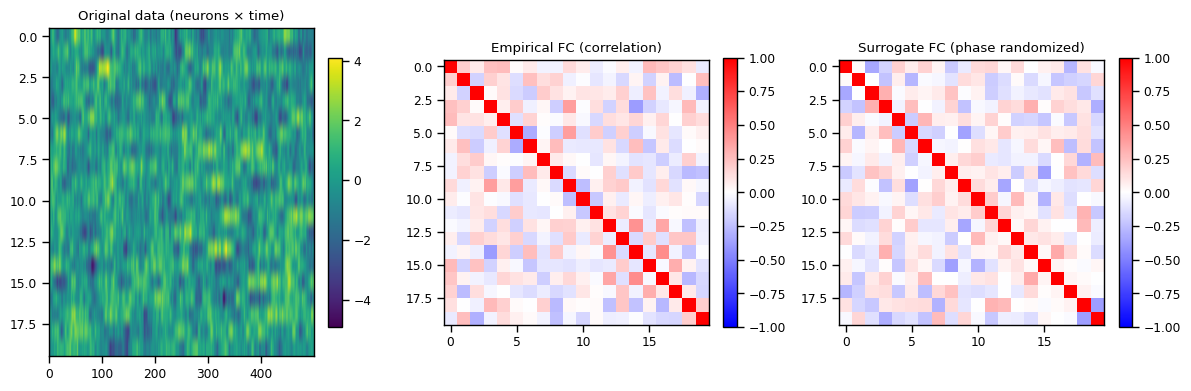

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import rfft, irfft

# --- helper: phase randomization for a single time series ---
def phase_randomize(ts, rng):
    """Phase-randomize a 1D time series while preserving power spectrum."""
    T = len(ts)
    X = rfft(ts)
    phases = np.exp(1j * rng.uniform(0, 2*np.pi, len(X)))
    phases[0] = 1.0  # keep DC component
    if T % 2 == 0:
        phases[-1] = 1.0  # keep Nyquist if present
    Xr = X * phases
    return irfft(Xr, n=T)

# --- synthetic dataset: N neurons x T timepoints ---
rng = np.random.default_rng(0)
N, T = 20, 500
# Each neuron: AR(1) process with slight noise, plus some shared global signal
time = np.arange(T)
global_signal = np.sin(2*np.pi*time/50)  # shared oscillation
data = np.zeros((N, T))
for i in range(N):
    noise = rng.normal(scale=0.5, size=T)
    x = np.zeros(T)
    for t in range(1, T):
        x[t] = 0.9*x[t-1] + noise[t]  # AR(1)
    data[i] = x + 0.3*global_signal  # add shared component

# --- compute FC (Pearson correlation) ---
def compute_fc(data):
    data_z = (data - data.mean(axis=1, keepdims=True)) / (data.std(axis=1, keepdims=True)+1e-12)
    return np.corrcoef(data_z)

fc_emp = compute_fc(data)

# --- make one surrogate dataset (phase randomized) ---
surrogate = np.zeros_like(data)
for i in range(N):
    surrogate[i] = phase_randomize(data[i], rng)

fc_surr = compute_fc(surrogate)

# --- plot comparison ---
fig, axs = plt.subplots(1, 3, figsize=(12,4))
im0 = axs[0].imshow(data, aspect='auto', cmap='viridis')
axs[0].set_title("Original data (neurons × time)")
plt.colorbar(im0, ax=axs[0], fraction=0.046)

im1 = axs[1].imshow(fc_emp, vmin=-1, vmax=1, cmap='bwr')
axs[1].set_title("Empirical FC (correlation)")
plt.colorbar(im1, ax=axs[1], fraction=0.046)

im2 = axs[2].imshow(fc_surr, vmin=-1, vmax=1, cmap='bwr')
axs[2].set_title("Surrogate FC (phase randomized)")
plt.colorbar(im2, ax=axs[2], fraction=0.046)

plt.tight_layout()
plt.show()


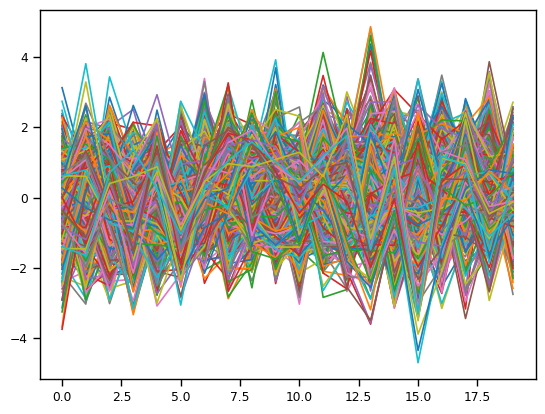

In [51]:
plt.plot(surrogate)
plt.show()

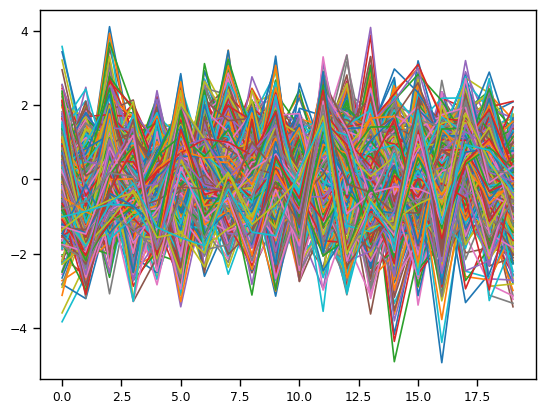

In [52]:
plt.plot(data)
plt.show()